# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Exploration of Data


## 1. Portfolio Dataframe

In [1]:
import pandas as pd
import numpy as np
import math
import json
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import classification_report
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


## 2. Profile Dataframe

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Checking null values in profile dataframe

In [7]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
profile[profile['gender'].isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [9]:
len(profile[profile['gender'].isnull()]['income'])

2175

All missing gender, income values have age 118

## 3. Transcript Dataframe

In [10]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [12]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [13]:
len(transcript['person'].unique())

17000

In [14]:
len(transcript['event'].unique())

4

# Cleaning Data

## 1. Portfolio Dataframe

* Covertinng channels column into dummy columns
* Renaming id to offer_id

In [15]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [16]:
dfpo = portfolio.copy()
dummy = pd.get_dummies(dfpo.channels.apply(pd.Series).stack()).sum(level=0)
dfpo = pd.concat([dfpo, dummy], axis=1)
dfpo = dfpo.drop(columns='channels')

In [17]:
dfpo = dfpo.rename(columns={'id':'offer_id'})

In [18]:
dfpo.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


## 2. Profile Dataframe

* Imputed null values in age, gender, income values with mean/mode
* Changed format of became_member_on column

In [19]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [20]:
dfpr = profile.copy()
dfpr['income'] = dfpr['income'].fillna(dfpr['income'].mean())
dfpr['age'] = dfpr['age'].fillna(dfpr['age'].mean())
dfpr['gender'] = dfpr['gender'].fillna(dfpr['gender'].mode()[0])
dfpr['became_member_on'] = pd.to_datetime(dfpr['became_member_on'], format='%Y%m%d')
dfpr = dfpr.rename(columns={'id':'user_id'})

In [21]:
dfpr.head()

,age,became_member_on,gender,user_id,income
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,2017-08-04,M,a03223e636434f42ac4c3df47e8bac43,65404.991568


## 3. Transcript Dataframe

* Renaming person to user_id
* Making dummy columns for event column
* Changed value column to 2 columns based on whether it had offer id or amount

In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
dftr = transcript.copy()

In [24]:
dftr = dftr.rename(columns={'person':'user_id'})

In [25]:
dummy = pd.get_dummies(dftr['event'])
dftr = pd.concat([dftr, dummy], axis=1 )


In [26]:
dftr['offer_id'] = [[*i.values()][0] if [*i.keys()][0] in ['offer id', 'offer_id'] else None for i in dftr.value] 
dftr['amount'] = [[*i.values()][0] if [*i.keys()][0] in ['amount'] else None for i in dftr.value] 

In [27]:
dftr.head()

,event,user_id,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [28]:
dftr = dftr.drop('event', axis =1)

In [29]:
dftr.head()

,user_id,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## Merging the 3 datasets

In [30]:
df_merged = pd.merge(dfpo, dftr, on='offer_id', how = 'left')
df_merged = pd.merge(df_merged, dfpr, on='user_id', how = 'left')

In [31]:
df_merged.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,user_id,...,value,offer completed,offer received,offer viewed,transaction,amount,age,became_member_on,gender,income
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,64,2017-09-09,M,100000.0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1e9420836d554513ab90eba98552d0a9,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,22,2017-09-25,M,70000.0
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,02c083884c7d45b39cc68e1314fec56c,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,20,2016-07-11,F,30000.0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,676506bad68e4161b9bbaffeb039626b,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,37,2017-05-15,M,92000.0
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,fe8264108d5b4f198453bbb1fa7ca6c9,...,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,1,0,0,NaN,78,2016-10-09,F,93000.0


In [32]:
df_merged = df_merged.drop('transaction', axis=1)
df_merged.describe()


,difficulty,duration,reward,email,mobile,social,web,time,offer completed,offer received,offer viewed,amount,age,income
count,167581.000000,167581.000000,167581.00000,167581.0,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,167581.000000,0.0,167581.000000,167581.000000
mean,7.850401,6.610737,4.41991,1.0,0.917944,0.656996,0.806858,353.778412,0.200375,0.455165,0.344460,NaN,61.862616,66301.055142
std,5.048944,2.136130,3.37336,0.0,0.274451,0.474714,0.394765,198.301287,0.400282,0.497987,0.475193,NaN,25.693155,20259.401992
min,0.000000,3.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,18.000000,30000.000000
25%,5.000000,5.000000,2.00000,1.0,1.000000,0.000000,1.000000,168.000000,0.000000,0.000000,0.000000,NaN,45.000000,52000.000000
50%,10.000000,7.000000,5.00000,1.0,1.000000,1.000000,1.000000,408.000000,0.000000,0.000000,0.000000,NaN,58.000000,65404.991568
75%,10.000000,7.000000,5.00000,1.0,1.000000,1.000000,1.000000,510.000000,0.000000,1.000000,1.000000,NaN,72.000000,78000.000000
max,20.000000,10.000000,10.00000,1.0,1.000000,1.000000,1.000000,714.000000,1.000000,1.000000,1.000000,NaN,118.000000,120000.000000


# Data Vizualization & Observations

In [33]:
df_merged.shape

(167581, 20)

### Most Sent Offer 

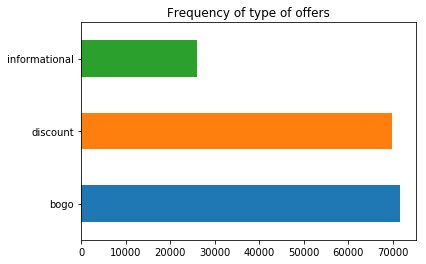

In [34]:
df_merged['offer_type'].value_counts().plot.barh(title='Frequency of type of offers')

BOGO & Discount are the offers which are sent out on a much more regular bases than informational offers

### Gender Distribution

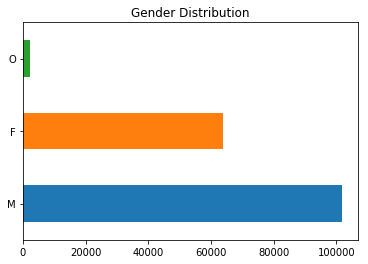

In [35]:
df_merged['gender'].value_counts().plot.barh(title='Gender Distribution')

Males dominate the gender distribution

### Salary Distribution

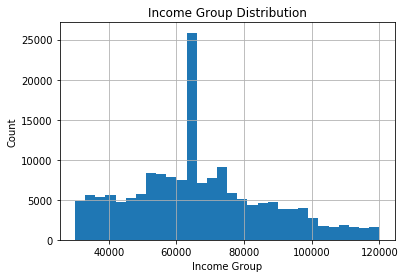

In [36]:
df_merged.income.hist(bins = 30)
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group Distribution');

Most people are middle class with income about 70000

### Proportion of viewed & completed offers

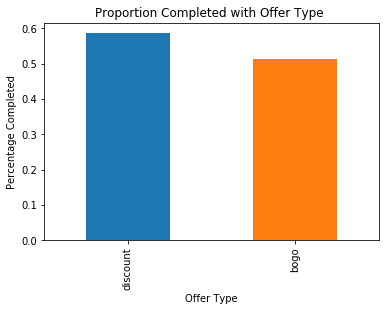

In [37]:
offer_received = df_merged[df_merged['offer received'] == 1].offer_type.value_counts()[0:2]
offer_completed = df_merged[df_merged['offer completed'] == 1].offer_type.value_counts()[0:2]
proportion = offer_completed/offer_received
proportion.plot(kind='bar')
plt.ylabel('Percentage Completed')
plt.xlabel('Offer Type')
plt.title('Proportion Completed with Offer Type ');

<b> Observation: Around 60% people who received discount offer went on to complete it and for BOGO around 50% completed it </b>

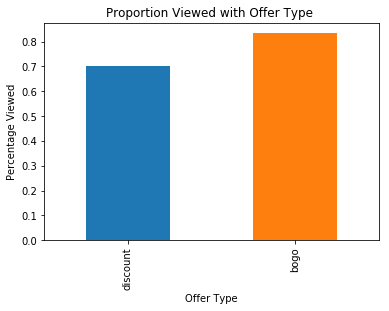

In [38]:
offer_received = df_merged[df_merged['offer received'] == 1].offer_type.value_counts()[0:2]
offer_viewed = list(reversed(df_merged[df_merged['offer viewed'] == 1].offer_type.value_counts()[0:2]))
proportion = offer_viewed/offer_received
proportion.plot(kind='bar')
plt.ylabel('Percentage Viewed')
plt.xlabel('Offer Type')
plt.title('Proportion Viewed with Offer Type ');

<b> More than 80% who received the BOGO offer viewed it and around 70% who received the discount offer viewed it </b>

# Modelling

## Some Additional Cleaning

In [39]:
df_merged[df_merged['offer_type'] == 'bogo']['offer_id'].describe()

count                                71617
unique                                   4
top       f19421c1d4aa40978ebb69ca19b0e20d
freq                                 19131
Name: offer_id, dtype: object

Converting categorical columns to numerical

In [40]:
# Encoding the offer_type column
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
df_merged['offer_type'] = df_merged['offer_type'].map(offers)

In [41]:
# Encoding the gender column
genders = {'O': 0, 'M': 1, 'F': 2}
df_merged['gender'] = df_merged['gender'].map(genders)
df_merged['amount'] = df_merged['amount'].fillna(0)

In [42]:
# Shuffling the merged dataframe and sorting by time column
df_merged = df_merged.sample(frac=1).sort_values(by = ['time'])
df_merged.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,user_id,time,value,offer completed,offer received,offer viewed,amount,age,became_member_on,gender,income
152804,10,7,2906b810c7d4411798c6938adc9daaa5,1,2,1,1,0,1,d33d6ec6e0864025b9209e7a7792b90d,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0.0,71,2018-06-29,1,36000.0
18879,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10,1,1,1,1,6c91c43f2a1c422dba831c60e7306ac0,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0.0,42,2014-10-27,1,66000.0
1480,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,10,1,1,1,0,b24ceb64aaa64fc1b4fb8b23d5f31203,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,1,0.0,28,2017-07-30,1,65000.0
64434,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,5,1,0,0,1,7e795099f75645b997a137f4a63fcde4,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0.0,84,2016-09-04,1,37000.0
118393,0,3,5a8bc65990b245e5a138643cd4eb9837,2,0,1,1,1,0,28416e7d96d746fb9c1fb8223d9e4914,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,1,0,0.0,74,2015-09-24,2,75000.0


## Preparing Data For FunkSVD

In [43]:
def create_user_item_matrix(filename, df):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # creating empty user item matrix by unstacking merged dataframe
    user_item_matrix = df.groupby(['user_id', 'offer_id'])['offer_type'].apply(lambda x: np.nan).unstack()
    print(user_item_matrix.shape)
    
    # Loop through every offer
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        
        #Loop through every user
        for user in user_item_matrix.index:
            events = []
            # Check the series of events
            for event in df[(df['offer_id']==offer_id) & (df['user_id']==user)][['offer received', 'offer viewed', 'offer completed']].values:
                events.extend(event)
            if len(events) >= 9:
                user_item_matrix.loc[user, offer_id] = 0
                for i in range(int(len(events)/3) - 2):
                    
                    # If events order is received, viewed and completed, add 1 else 0
                    if (events[3*i] == 1) & (events[3*(i+1)+1] == 1) & (events[3*(i+2)+2] == 1):
                        user_item_matrix.loc[user, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[user, offer_id] = 0
    
    # store the user item martix into pickle file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [44]:
# Split dataset into test and train
train_offer = df_merged[:int(df_merged.shape[0]*0.7)]
test_offer = df_merged[int(df_merged.shape[0]*0.7):]


In [169]:
# Leave the following lines commented to save time as the needed files are saved as pickle files
#train_matrix = create_user_item_matrix('train_matrix.p', train_offer)
#test_matrix = create_user_item_matrix('test_matrix.p', test_offer)
#user_item_matrix = create_user_item_matrix('user_item_matrix.p', df_merged)


(15815, 10)
Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
Now processing:  2906b810c7d4411798c6938adc9daaa5
Now processing:  3f207df678b143eea3cee63160fa8bed
Now processing:  4d5c57ea9a6940dd891ad53e9dbe8da0
Now processing:  5a8bc65990b245e5a138643cd4eb9837
Now processing:  9b98b8c7a33c4b65b9aebfe6a799e6d9
Now processing:  ae264e3637204a6fb9bb56bc8210ddfd
Now processing:  f19421c1d4aa40978ebb69ca19b0e20d
Now processing:  fafdcd668e3743c1bb461111dcafc2a4


## Load Test & Train Data

In [45]:
# Load the matrices
user_item_matrix = pd.read_pickle('user_item_matrix.p')
train_matrix = pd.read_pickle('train_matrix.p')
test_matrix = pd.read_pickle('test_matrix.p')

In [46]:
def FunkSVD(user_item_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using FunkSVD
    
    INPUT:
    user_item_mat -  Matrix with users as rows, offers as columns, offer completed as values
    latent_features - number of latent features to be used
    learning_rate - learning rate 
    iters - number of iterations to be performed
    
    OUTPUT:
    user_mat - user by latent feature matrix
    offer_mat - latent feature by offer matrix
    '''
    
    num_nonzero = np.count_nonzero(~np.isnan(user_item_mat))
    
    # initialize user and offer matrices
    user_latent_mat = np.random.rand(user_item_mat.shape[0], latent_features)
    offer_latent_mat = np.random.rand(latent_features, user_item_mat.shape[1])
    
    # initialize error
    mse_total = 0
    
    print("Iteration Number | MSE ")
    
    for iteration in range(iters):
        
        old_mse = mse_total
        mse_total = 0
        
        # Loop through every user
        for i in range(user_item_mat.shape[0]):
            
            #Loop through every offer
            for j in range(user_item_mat.shape[1]):
                
                if user_item_mat[i, j] >= 0:
                    
                    # Take difference of predicted and actual
                    diff = user_item_mat[i, j] - np.dot(user_latent_mat[i, :], offer_latent_mat[:, j])
                    
                    # Update mse
                    mse_total = mse_total + diff**2
                    
                    # apply gradient descent
                    for k in range(latent_features):
                        user_latent_mat[i, k] += learning_rate * (2*diff*offer_latent_mat[k, j])
                        offer_latent_mat[k, j] += learning_rate * (2*diff*user_latent_mat[i, k])

        print("%d \t\t %f" % (iteration+1, mse_total / num_nonzero))
        
    return user_latent_mat, offer_latent_mat

In [47]:
train_matrix_np = np.array(train_matrix)

In [48]:
def predict_offers(user_latent_matrix, offer_latent_matrix, user_id, offer_id):
    '''
    This function returns predictions of how a user would react to a given offer
    
    INPUT:
    user_latent_matrix - user by latent factor matrix
    offer_ltent_matrix - latent factor by offer matrix
    user_id - user_id from database
    offer_id - offer_id from database
    
    OUTPUT:
    pred - predicted value for user_id-offer_id based on FunkSVD function
    '''
    try:
        # Finding the index of the input user id and offer id
        user_ids = np.array(train_matrix.index)
        offer_ids = np.array(train_matrix.columns)

        user_row = np.where(user_ids == user_id)[0][0]
        offer_col = np.where(offer_ids == offer_id)[0][0]

        # Return the dot product of user row and offer column as predicted value
        pred = np.dot(user_latent_matrix[user_row, :], offer_latent_matrix[:, offer_col])
        
        return pred
    
    except:
        print("User or offer or both do not exist")
        return None

In [49]:
def validation(test_matrix, user_latent_mat, offer_latent_mat):
    '''Measures the squared error for the predicted reaction of users to offers
    
    INPUT:
    test_matrix: Matrix with users as rows, offers as columns, offer completed as values
    user_latent_mat -  user by latent factor matrix
    offer_latent_mat - latent factor by offer matrix
    
    OUTPUT: Mean of sum of squared errors
    
    '''
    num_nonzero = np.count_nonzero(~np.isnan(test_matrix))
    
    mse_total = 0
    
    # loop through every user
    for user_id in test_matrix.index:
        
        #loop through every offer
        for offer_id in test_matrix.columns:
            if ~np.isnan(test_matrix.loc[user_id, offer_id]):
                predict_value = predict_offers(user_latent_mat, offer_latent_mat, user_id, offer_id)
                if predict_value != None:
                    
                    # take difference of predicted and actual value
                    diff = test_matrix.loc[user_id, offer_id] - predict_reaction(user_latent_mat, offer_latent_mat, user_id, offer_id)

                    # update the mse
                    mse_total += diff**2
    
    print(mse_total / num_nonzero)
    return mse_total / num_nonzero

In [50]:
def validationplot(j,k):
    '''
    Plots number of iterations vs error for different number of latent features
    
    INPUT:
    j - number of iterations/50
    k - number of latent features/5
    '''
    a = []
    # loop through number of latent features
    for m in range(k):
        
        # loop through number of iterations
        b = [50*(i+1) for i in range(j)]
        for i in range(j):
            user_latent_mat, offer_latent_mat = FunkSVD(train_matrix_np, latent_features=5*(m+1), learning_rate=0.005, iters=50*(i+1))
            a.append(validation(test_matrix, user_latent_mat, offer_latent_mat))
        
        
        print(b)
        print(a)
        plt.plot(b,a)   
        a=[]
        b=[]
        
    plt.legend(["5", "10", "15"])
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error')
    plt.title('Iterations vs Error for latent features');

Iterations | MSE 
1 		 0.197846
2 		 0.186710
3 		 0.186353
4 		 0.185993
5 		 0.185633
6 		 0.185272
7 		 0.184910
8 		 0.184548
9 		 0.184185
10 		 0.183821
11 		 0.183457
12 		 0.183092
13 		 0.182726
14 		 0.182359
15 		 0.181992
16 		 0.181624
17 		 0.181255
18 		 0.180885
19 		 0.180514
20 		 0.180142
21 		 0.179770
22 		 0.179396
23 		 0.179021
24 		 0.178646
25 		 0.178269
26 		 0.177890
27 		 0.177511
28 		 0.177130
29 		 0.176748
30 		 0.176364
31 		 0.175979
32 		 0.175592
33 		 0.175204
34 		 0.174813
35 		 0.174421
36 		 0.174027
37 		 0.173630
38 		 0.173232
39 		 0.172831
40 		 0.172427
41 		 0.172021
42 		 0.171612
43 		 0.171200
44 		 0.170786
45 		 0.170367
46 		 0.169946
47 		 0.169521
48 		 0.169092
49 		 0.168659
50 		 0.168221
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not ex

User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or bot

119 		 0.101477
120 		 0.100061
121 		 0.098648
122 		 0.097240
123 		 0.095837
124 		 0.094441
125 		 0.093053
126 		 0.091672
127 		 0.090302
128 		 0.088941
129 		 0.087591
130 		 0.086253
131 		 0.084927
132 		 0.083614
133 		 0.082314
134 		 0.081029
135 		 0.079758
136 		 0.078502
137 		 0.077261
138 		 0.076036
139 		 0.074827
140 		 0.073635
141 		 0.072458
142 		 0.071298
143 		 0.070155
144 		 0.069029
145 		 0.067919
146 		 0.066827
147 		 0.065751
148 		 0.064692
149 		 0.063651
150 		 0.062626
151 		 0.061617
152 		 0.060626
153 		 0.059651
154 		 0.058692
155 		 0.057750
156 		 0.056824
157 		 0.055913
158 		 0.055019
159 		 0.054140
160 		 0.053277
161 		 0.052429
162 		 0.051596
163 		 0.050778
164 		 0.049974
165 		 0.049185
166 		 0.048410
167 		 0.047650
168 		 0.046903
169 		 0.046170
170 		 0.045450
171 		 0.044744
172 		 0.044051
173 		 0.043370
174 		 0.042702
175 		 0.042047
176 		 0.041404
177 		 0.040773
178 		 0.040154
179 		 0.039547
180 		 0.038951
181 		 0

User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or bot

174 		 0.025464
175 		 0.024961
176 		 0.024469
177 		 0.023986
178 		 0.023513
179 		 0.023049
180 		 0.022594
181 		 0.022148
182 		 0.021711
183 		 0.021282
184 		 0.020862
185 		 0.020450
186 		 0.020047
187 		 0.019651
188 		 0.019264
189 		 0.018884
190 		 0.018512
191 		 0.018147
192 		 0.017790
193 		 0.017440
194 		 0.017097
195 		 0.016761
196 		 0.016432
197 		 0.016110
198 		 0.015794
199 		 0.015485
200 		 0.015182
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or 

18 		 0.185398
19 		 0.185192
20 		 0.184981
21 		 0.184765
22 		 0.184544
23 		 0.184317
24 		 0.184084
25 		 0.183845
26 		 0.183598
27 		 0.183345
28 		 0.183084
29 		 0.182814
30 		 0.182536
31 		 0.182248
32 		 0.181951
33 		 0.181643
34 		 0.181325
35 		 0.180995
36 		 0.180652
37 		 0.180297
38 		 0.179927
39 		 0.179544
40 		 0.179145
41 		 0.178729
42 		 0.178297
43 		 0.177846
44 		 0.177377
45 		 0.176888
46 		 0.176378
47 		 0.175846
48 		 0.175290
49 		 0.174711
50 		 0.174106
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer o

User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or bot

135 		 0.044627
136 		 0.043676
137 		 0.042746
138 		 0.041837
139 		 0.040946
140 		 0.040076
141 		 0.039225
142 		 0.038392
143 		 0.037578
144 		 0.036783
145 		 0.036005
146 		 0.035245
147 		 0.034502
148 		 0.033776
149 		 0.033067
150 		 0.032374
151 		 0.031697
152 		 0.031035
153 		 0.030389
154 		 0.029757
155 		 0.029140
156 		 0.028538
157 		 0.027949
158 		 0.027374
159 		 0.026812
160 		 0.026263
161 		 0.025726
162 		 0.025202
163 		 0.024690
164 		 0.024189
165 		 0.023700
166 		 0.023222
167 		 0.022755
168 		 0.022298
169 		 0.021851
170 		 0.021415
171 		 0.020988
172 		 0.020570
173 		 0.020162
174 		 0.019762
175 		 0.019371
176 		 0.018988
177 		 0.018614
178 		 0.018247
179 		 0.017889
180 		 0.017537
181 		 0.017193
182 		 0.016856
183 		 0.016526
184 		 0.016203
185 		 0.015886
186 		 0.015575
187 		 0.015271
188 		 0.014972
189 		 0.014679
190 		 0.014392
191 		 0.014111
192 		 0.013834
193 		 0.013563
194 		 0.013297
195 		 0.013036
196 		 0.012780
197 		 0

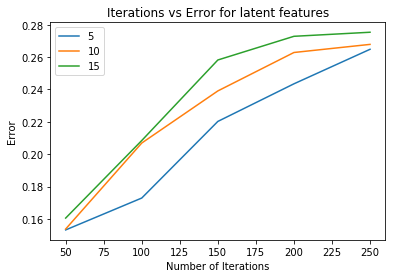

In [68]:
validationplot(5,3)

Iterations | MSE 
1 		 0.200575
2 		 0.187165
3 		 0.186805
4 		 0.186440
5 		 0.186075
6 		 0.185708
7 		 0.185340
8 		 0.184972
9 		 0.184602
10 		 0.184232
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
U

User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
0.150568426387
Iterations | MSE 
1 		 0.199150
2 		 0.187044
3 		 0.186685
4 		 0.186322
5 		 0.185958
6 		 0.185593
7 		 0.185227
8 		 0.184860
9 		 0.184492
10 		 0.184123
11 		 0.183752
12 		 0.183381
13 		 0.183008
14 		 0.182634
15 		 0.182259
16 		 0.181882
17 		 0.181504
18 		 0.181124
19 		 0.180742
20 		 0.180359
21 		 0.179974
22 		 0.179588
23 		 0.179199
24 		 0.178808
25 		 0.178415
26 		 0.178020
27 		 0.177623
28 		 0.177223
29 		 0.176820
30 		 0.176415
31 		 0.176007
32 		 0.175595
33 		 0.175181
34 		 0.174763
35 		 0.174341
36 		 0.173916
37 		 0.173486
38 		 0.173053
39 		 0.172615
40 		 0.172172
41 		 0.171725
42 		 0.171272
43 		 0.170814
44 		 0.170351
45 		 0.169881
46 		 0.169405
47 		 0.168923
48 		 0.168433
49 		 0.167936
50 		 0.167432
User or offer or

User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
0.149734497287
Iterations | MSE 
1 		 0.220090
2 		 0.187119
3 		 0.186905
4 		 0.186691
5 		 0.186476
6 		 0.186258
7 		 0.186039
8 		 0.185817
9 		 0.185593
10 		 0.185367
11 		 0.185138
12 		 0.184907
13 		 0.184672
14 		 0.184435
15 		 0.184194
16 		 0.183950
17 		 0.183703
18 		 0.183451
19 		 

User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or bot

User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
User or offer or both do not exist
0.163463688571
[10, 20, 30, 40, 50]
[0.14889451436267145, 0.15008507941736166, 0.15042491213581605, 0.15656916970954213, 0.16346368857050494]


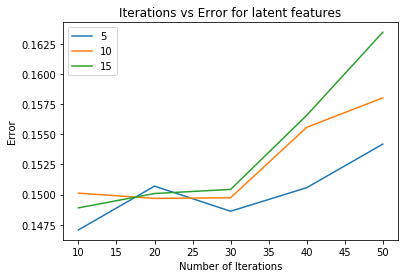

In [70]:
validationplot(5,3)

In [51]:
def top_offer(user_item_matrix):
    
    '''
    Returns the offers which have been completed the most
    
    INPUT:
    user_item_matrix - Matrix with users as rows, offers as columns, offer completed as values
    
    OUTPUT:
    b -  An array of top offer_ids
    
    '''
    temp = user_item_matrix.copy()
    a = []
    for offer_id in user_item_matrix.columns:
        a.append([user_item_matrix[offer_id].mean(), offer_id])
    b = pd.DataFrame(a, columns = ['completed_sum', 'offer_id'])    
    
    # sort offers by number of times it has been completed
    b.sort_values(by='completed_sum', ascending=False, inplace=True)
    return b
    

In [52]:
def recommend_offer(user_id, user_latent_mat, offer_latent_mat):
    '''
    Returns the top recommended offers for a given user id
    
    INPUT:
    user_id - a user id from the database
    user_latent_mat  - user by latent factor matrix
    offer_latent_mat - latent factor by offer matrix    
    '''
    # find predicted values of all offers for given user id
    recommend_values = {}
    for offer_id in user_item_matrix.columns:
        pred_val = predict_offers(user_latent_mat, offer_latent_mat, user_id, offer_id)
        if pred_val != None:
            recommend_values[offer_id] = pred_val
        else:
            break
    
    # return top offers for new user
    if pred_val == None:
        print("Returning the top offers for new user")
        top_offers = top_offer(user_item_matrix)
        for offer_id in top_offers['offer_id']:
            print("offer id: ", offer_id)
            
    # return best offers for existing users        
    else:
        print("Recommend offers for user ", user_id)
        for offer_id, pred_val in sorted(recommend_values.items(), key=lambda x:(x[1], x[0]), reverse=True):
            print("offer id: ", offer_id, " prediction: ", round(pred_val,2))
            


In [53]:
user_latent_mat, offer_latent_mat = FunkSVD(train_matrix_np, latent_features=5, learning_rate=0.005, iters=50)

Iteration Number | MSE 
1 		 0.200669
2 		 0.187661
3 		 0.187299
4 		 0.186936
5 		 0.186571
6 		 0.186205
7 		 0.185838
8 		 0.185471
9 		 0.185102
10 		 0.184732
11 		 0.184361
12 		 0.183989
13 		 0.183616
14 		 0.183242
15 		 0.182867
16 		 0.182490
17 		 0.182112
18 		 0.181732
19 		 0.181351
20 		 0.180968
21 		 0.180584
22 		 0.180198
23 		 0.179811
24 		 0.179421
25 		 0.179030
26 		 0.178637
27 		 0.178241
28 		 0.177844
29 		 0.177444
30 		 0.177042
31 		 0.176637
32 		 0.176229
33 		 0.175819
34 		 0.175405
35 		 0.174989
36 		 0.174569
37 		 0.174146
38 		 0.173719
39 		 0.173288
40 		 0.172854
41 		 0.172415
42 		 0.171972
43 		 0.171524
44 		 0.171071
45 		 0.170614
46 		 0.170151
47 		 0.169682
48 		 0.169207
49 		 0.168727
50 		 0.168239


In [54]:
user_item_matrix.index

Index(['0009655768c64bdeb2e877511632db8f', '00116118485d4dfda04fdbaba9a87b5c',
       '0011e0d4e6b944f998e987f904e8c1e5', '0020c2b971eb4e9188eac86d93036a77',
       '0020ccbbb6d84e358d3414a3ff76cffd', '003d66b6608740288d6cc97a6903f4f0',
       '00426fe3ffde4c6b9cb9ad6d077a13ea', '004b041fbfe44859945daa2c7f79ee64',
       '004c5799adbf42868b9cff0396190900', '005500a7188546ff8a767329a2f7c76a',
       ...
       'ffecb1f8543f4bf7bade023de366d6bf', 'ffed75d3abc64b488982f50ed12878b5',
       'ffede3b700ac41d6a266fa1ba74b4f16', 'fff0f0aac6c547b9b263080f09a5586a',
       'fff29fb549084123bd046dbc5ceb4faa', 'fff3ba4757bd42088c044ca26d73817a',
       'fff7576017104bcc8677a8d63322b5e1', 'fff8957ea8b240a6b5e634b6ee8eafcf',
       'fffad4f4828548d1b5583907f2e9906b', 'ffff82501cea40309d5fdd7edcca4a07'],
      dtype='object', name='user_id', length=16994)

In [55]:
recommend_offer('00116118485d4dfda04fdbaba9a87b5c', user_latent_mat, offer_latent_mat)


Recommend offers for user  00116118485d4dfda04fdbaba9a87b5c
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  prediction:  0.44
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  prediction:  0.36
offer id:  fafdcd668e3743c1bb461111dcafc2a4  prediction:  0.35
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  prediction:  0.27
offer id:  2906b810c7d4411798c6938adc9daaa5  prediction:  0.21
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  prediction:  0.18
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  prediction:  0.15
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  prediction:  0.14
offer id:  5a8bc65990b245e5a138643cd4eb9837  prediction:  0.0
offer id:  3f207df678b143eea3cee63160fa8bed  prediction:  -0.0


In [56]:
recommend_offer('ffed75d3abc64b488982f50ed12878b5', user_latent_mat, offer_latent_mat)


Recommend offers for user  ffed75d3abc64b488982f50ed12878b5
offer id:  fafdcd668e3743c1bb461111dcafc2a4  prediction:  0.58
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  prediction:  0.44
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  prediction:  0.41
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  prediction:  0.41
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  prediction:  0.28
offer id:  2906b810c7d4411798c6938adc9daaa5  prediction:  0.28
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  prediction:  0.19
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  prediction:  0.17
offer id:  5a8bc65990b245e5a138643cd4eb9837  prediction:  0.0
offer id:  3f207df678b143eea3cee63160fa8bed  prediction:  -0.0


In [57]:
recommend_offer('ffed75d3abc64b4889812878b5', user_latent_mat, offer_latent_mat)


User or offer or both do not exist
Returning the top offers for new user
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7
offer id:  3f207df678b143eea3cee63160fa8bed
offer id:  5a8bc65990b245e5a138643cd4eb9837
